In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import random
sys.path.append("..")
import numpy as np

def get_all_params_flattend(model):
    params = np.array([], dtype=np.float32)
    with torch.no_grad():
        params = np.concatenate((params, model.conv1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc2.bias.data.reshape(-1)))
    return params

from sklearn.preprocessing import StandardScaler
def standardization(all_params):
    all_params = StandardScaler().fit_transform(all_params)
    return all_params

from sklearn.preprocessing import MinMaxScaler
def normalization(all_params):
    norm = MinMaxScaler().fit_transform(all_params)
    return all_params

from sklearn.decomposition import PCA
def draw_pca_model(params_list, colors, title):
    pca = PCA(n_components=2)
    proj = pca.fit_transform(params_list)
    figure = plt.figure(figsize=(18, 8))
    plt.title(title)
    plt.scatter(proj[:, 0], proj[:,1], c = colors, cmap="rainbow") #gist_rainbow
    for ii in range(len(proj)):
        label = ""
        if ii == len(proj) - 1:
            label = "w_avg" 
        elif ii == len(proj) - 2:
            label = "w_0" 
        else:
            label = ii
        plt.annotate(label, (proj[ii, 0], proj[ii, 1]), textcoords="offset points", xytext=(5+random.random(),5+random.random()))
#     plt.scatter(proj[:, 0], proj[:,1], c = colors, cmap="rainbow") #gist_rainbow
#     plt.annotate("W0", (proj[len(proj) - 2, 0], proj[len(proj) - 2, 1]), textcoords="offset points", xytext=(5,5))
#     plt.annotate("weighted_avg", (proj[len(proj) - 1, 0], proj[len(proj) - 1, 1]), textcoords="offset points", xytext=(5,5))
    plt.colorbar(ticks=range(len(params_list)))

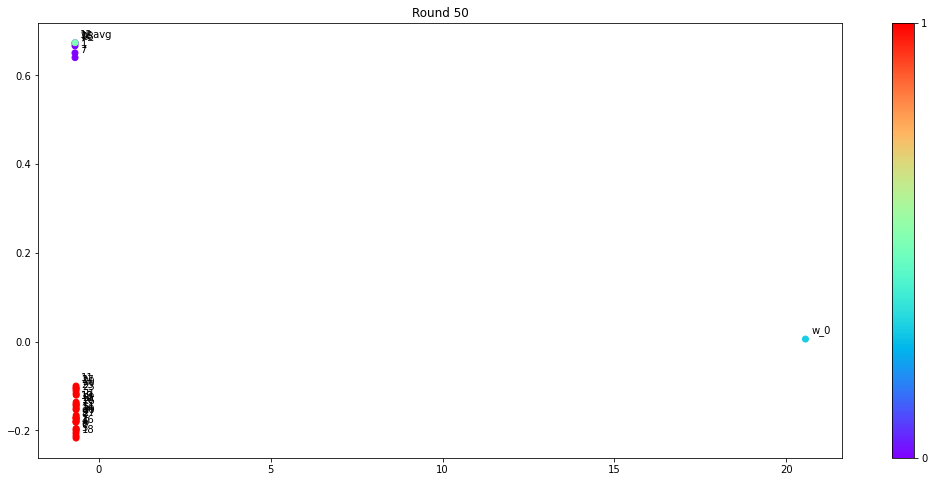

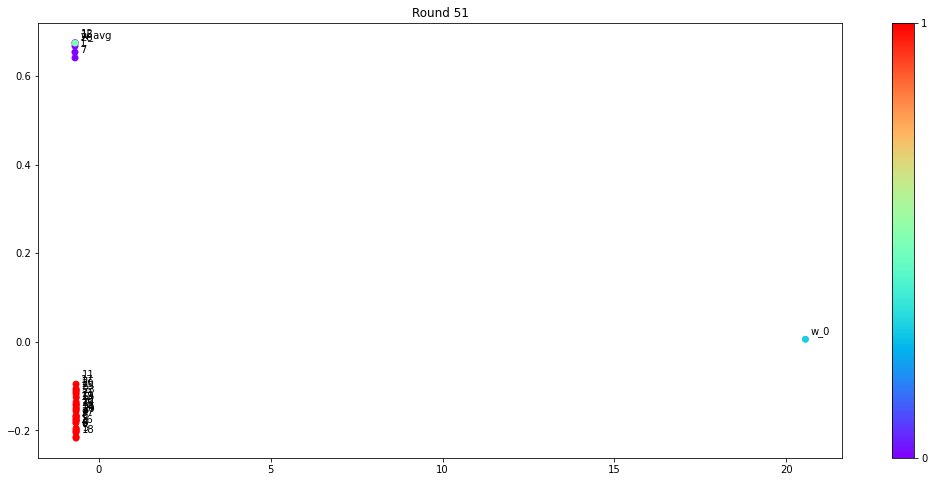

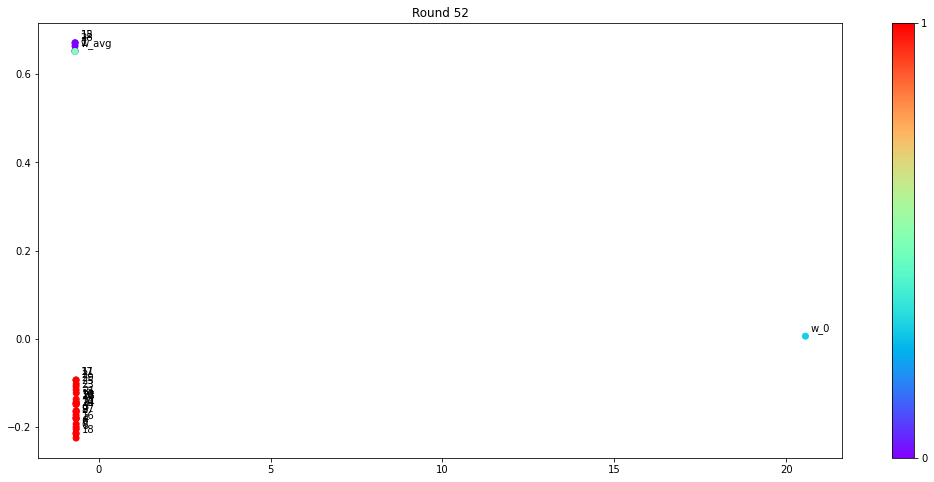

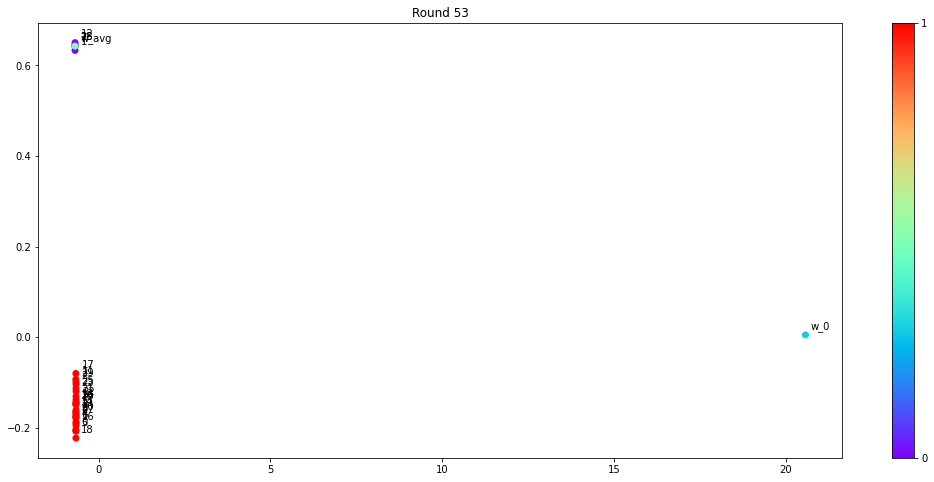

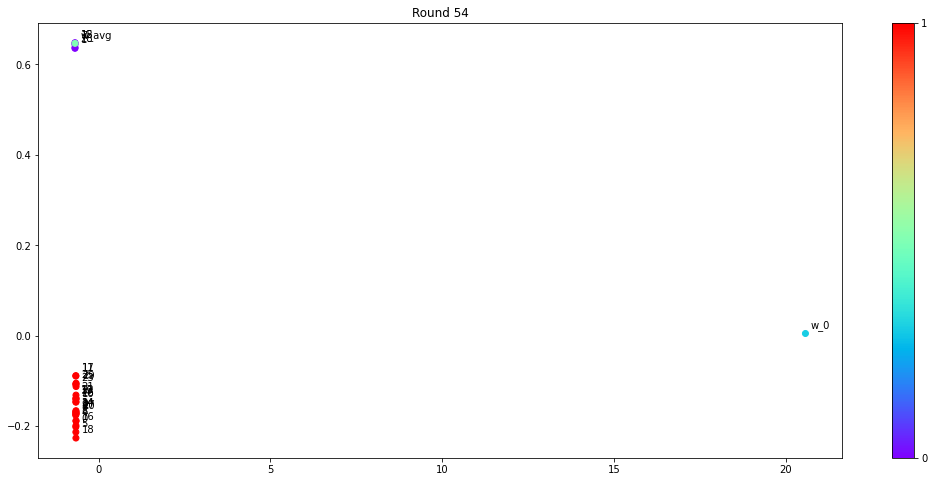

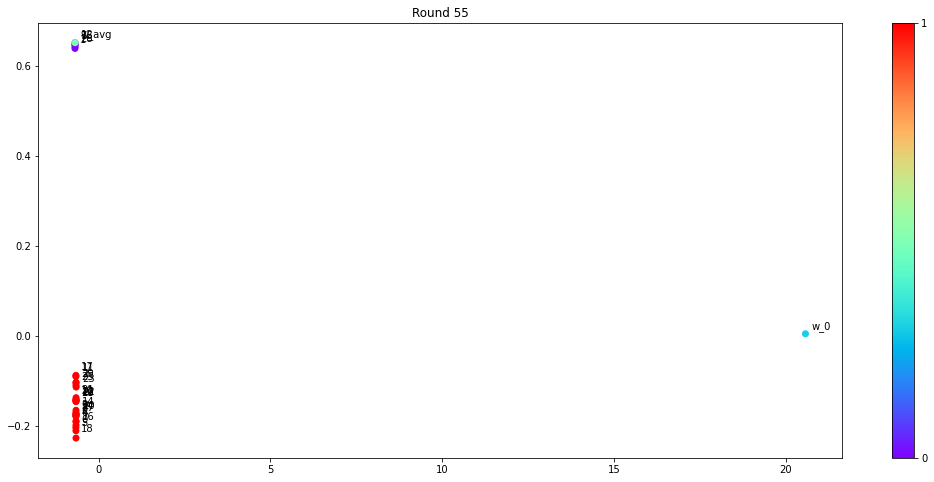

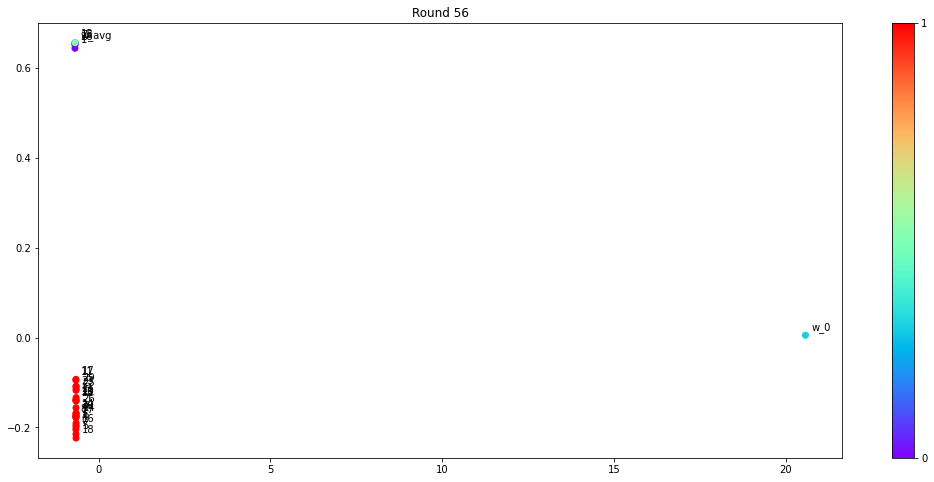

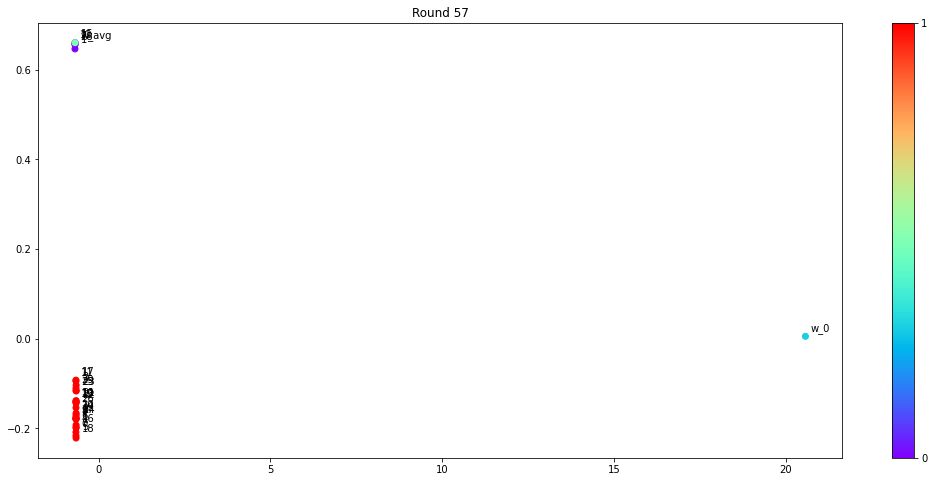

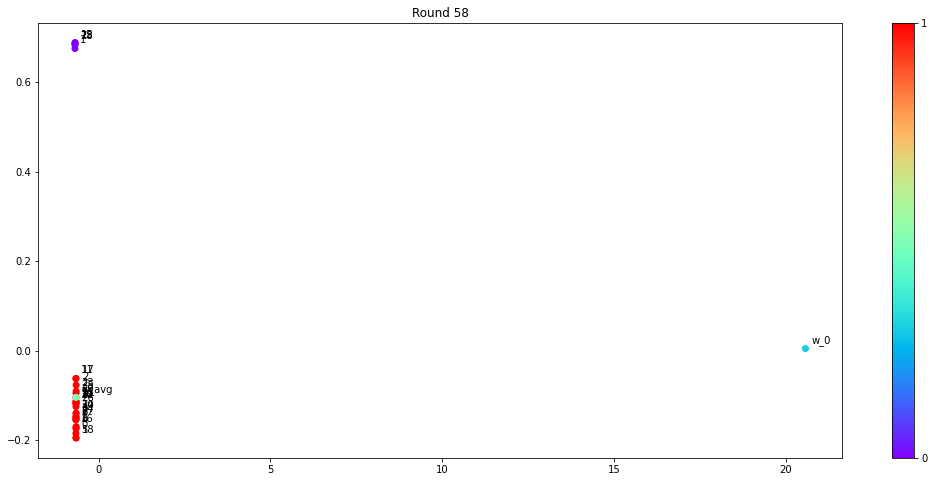

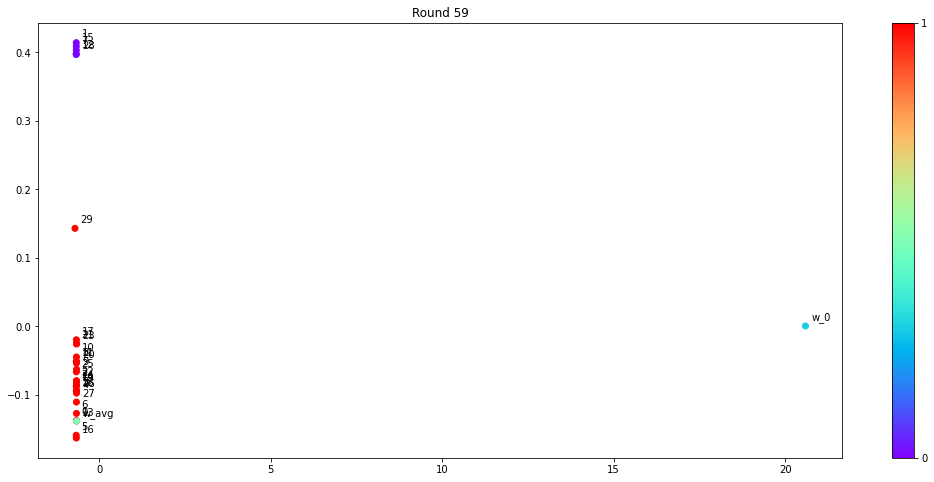

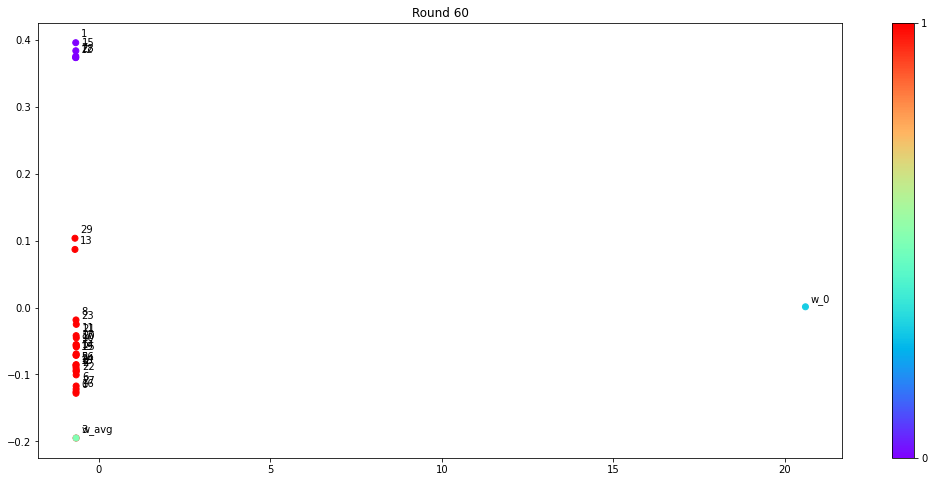

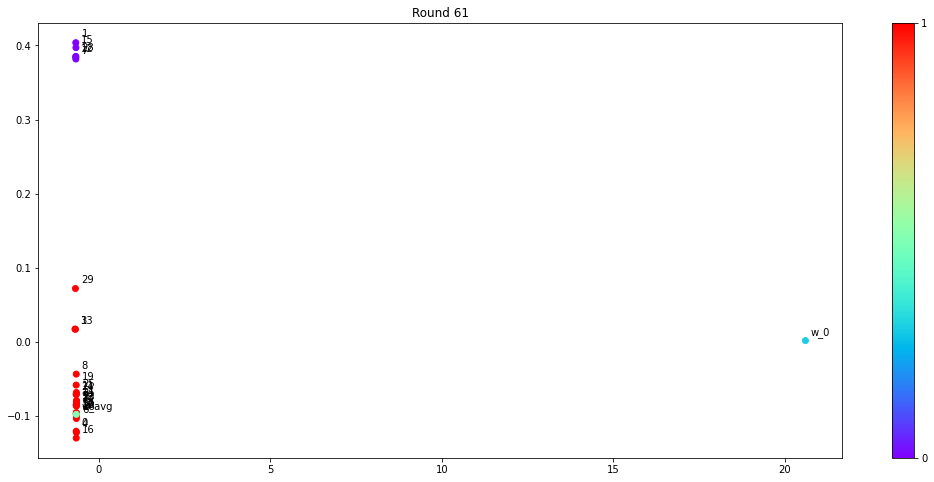

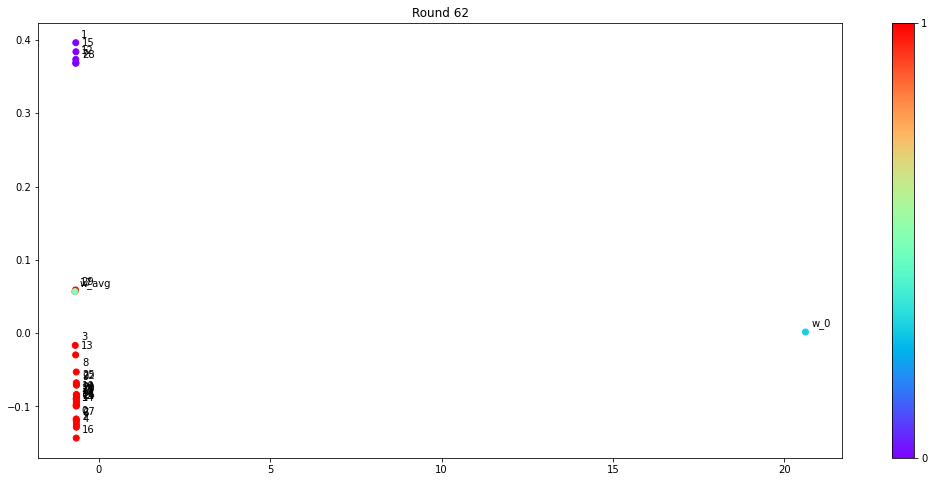

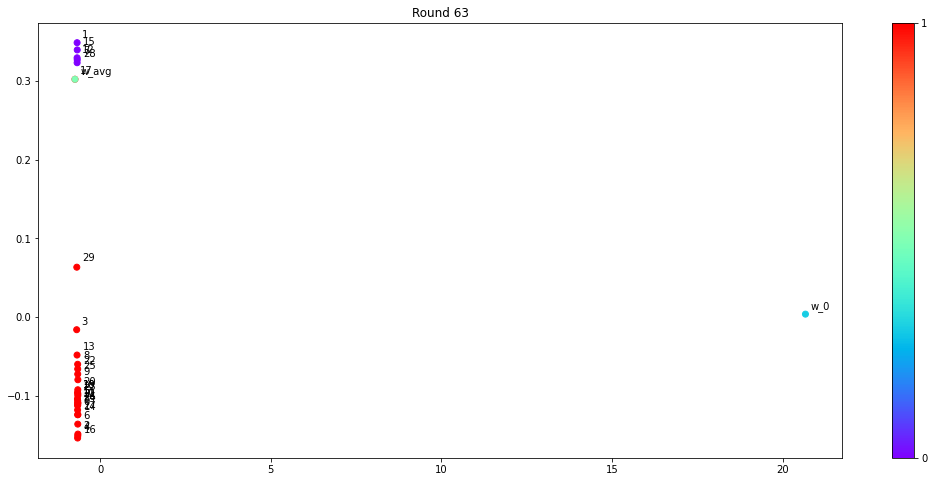

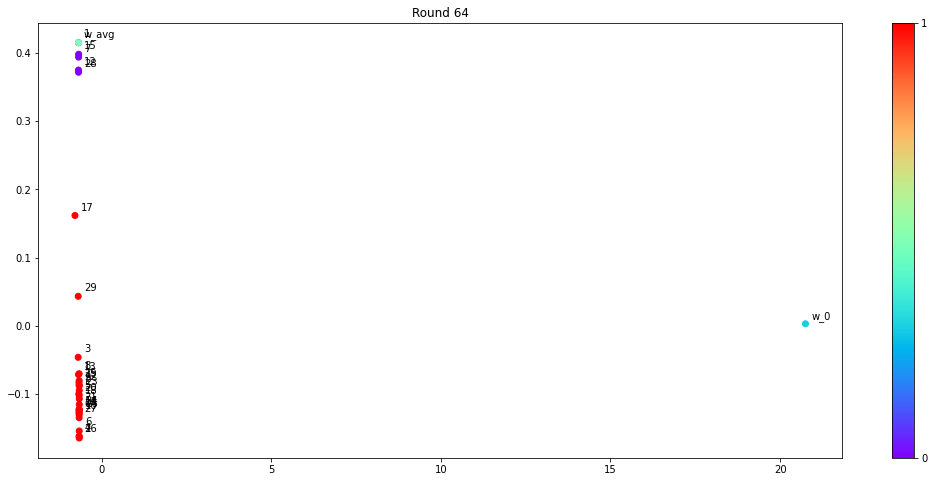

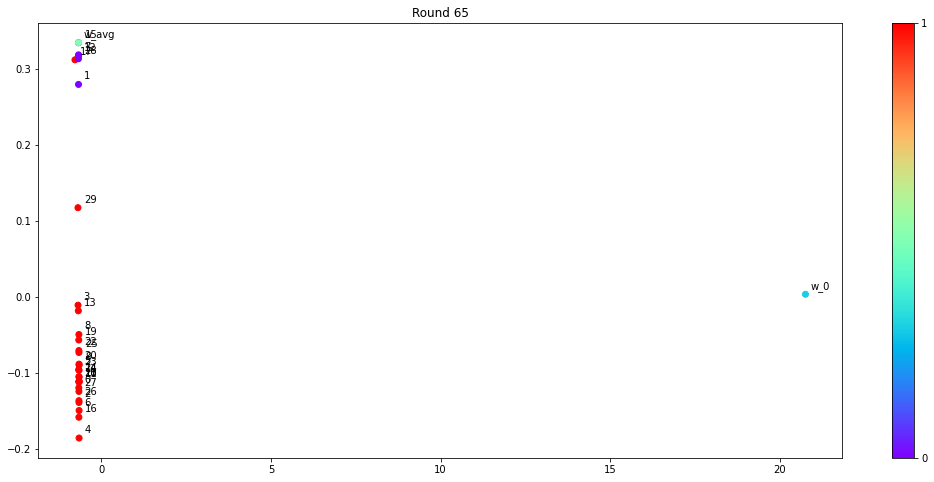

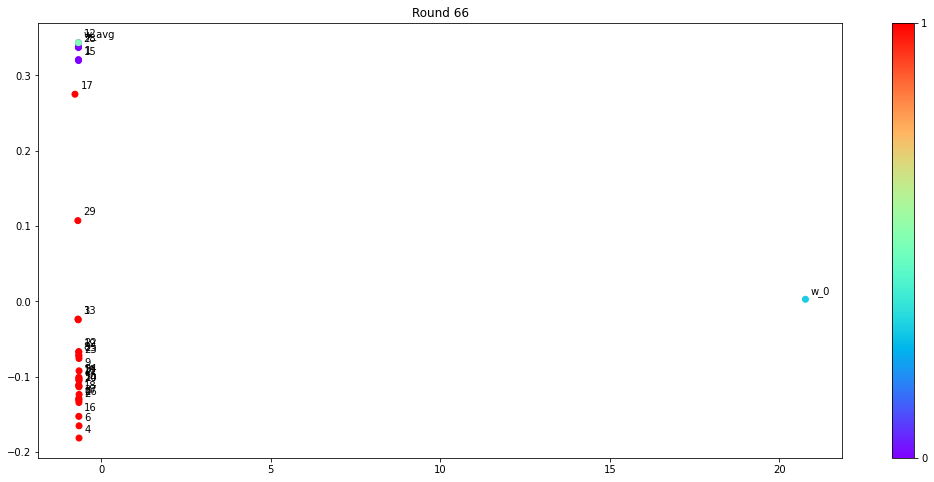

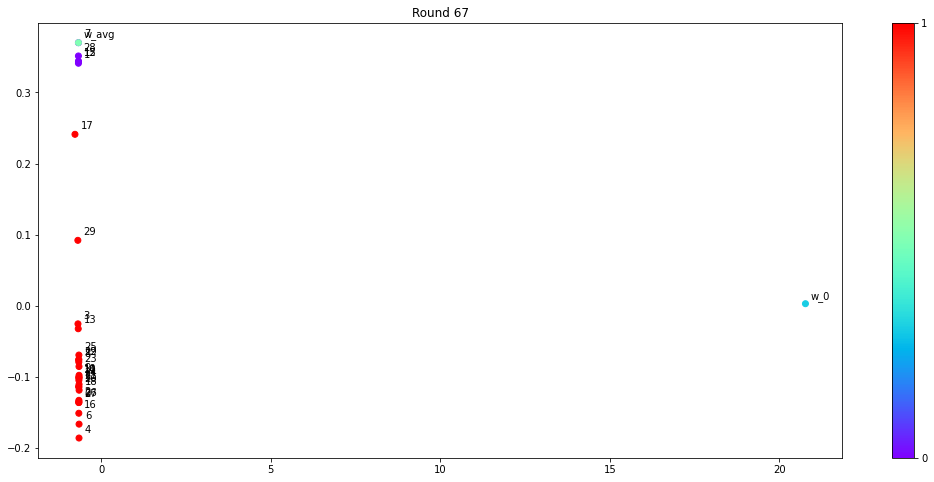

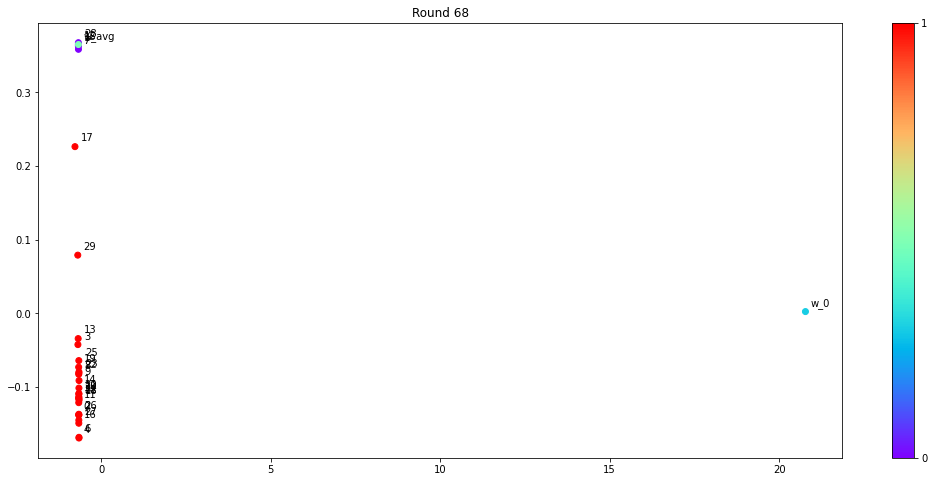

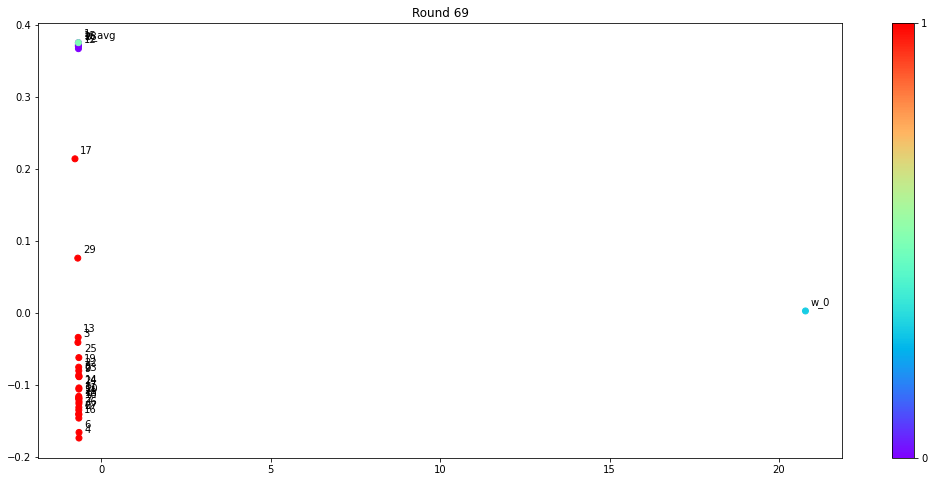

In [2]:
rounds = range(50,70, 1)
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
import numpy as np

file_path = "../data_output/20201203_100414_mnist_opt_w0_eav25_SAN_175"
w0_path = "../data_output/20201108_225254_mnist_w0_SAN_125/models/server_model_49"

all_params = np.array([], dtype=np.float32).reshape(-1, 431570) 
# 431570 is the nmber of all params in a model
    
path = "{}/{}".format(file_path, "eavesdroppers")
with open(path, 'r') as f:
    eavesdoppers_idx = [str(i) for i in f.readlines()[0].replace('[','').\
                   replace(']','').replace('\n','').replace('\'','').split(', ')]
    
path = "{}/{}".format(file_path, "normal")
with open(path, 'r') as f:
    normal_idx = [str(i) for i in f.readlines()[0].replace('[','').\
                   replace(']','').replace('\n','').replace('\'','').split(', ')]
workers_idx = []
for ii in range(len(eavesdoppers_idx + normal_idx)):
    workers_idx.append("worker_{}".format(ii))
# workers_idx =  eavesdoppers_idx + normal_idx

color_map = []
for ww in workers_idx:
    if ww in eavesdoppers_idx:
        color_map.append(1.0)
    elif ww in normal_idx:
        color_map.append(0)

# For the w0        
color_map.append(0.3)
        
# For the weighted_avg_model
color_map.append(0.5) 

for rr in rounds:
    all_params = np.array([], dtype=np.float32).reshape(-1, 431080) 
    # 431080 is the nmber of all params in a model
    for ww in workers_idx:
        model_path = "{}/models/R{}_{}".format(file_path, rr, ww)
        worker_model = torch.load(model_path)
        params = get_all_params_flattend(worker_model).reshape(1, -1)
        all_params = np.concatenate((all_params, params))
    
    w0_model = torch.load(w0_path)
    w0_params= get_all_params_flattend(w0_model).reshape(1, -1)
    all_params = np.concatenate((all_params, w0_params))
    
    weighted_avg_path = "{}/models/R{}_weighted_avg_model".format(file_path, rr)
    weighted_avg_model = torch.load(weighted_avg_path)
    weighted_avg_params= get_all_params_flattend(weighted_avg_model).reshape(1, -1)
    all_params = np.concatenate((all_params, weighted_avg_params))

    all_params = normalization(all_params)
    draw_pca_model(all_params, color_map, "Round {}".format(rr))

